# BLIP captioning

> Fill in a module description here

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import json
import math
import os

import autotrace
import numpy as np
import pandas as pd
from PIL import Image

# import tensorflow as tf
# from tensorboard.plugins import projector


# from fastai.vision.all import *
# from portfolio_search.embeddings import *
from singleline_dataset.fileorg import *

In [ ]:
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from datasets import load_dataset

## Loading TSV's and Input Images

In [ ]:
# autotrace_dir = "{singleline_data_home()}/svg/epoch-20231214/"

In [ ]:
preprocessed_dir = (
    singleline_data_home() / "raster/epoch-20231214/10_SIMPLE_CROP"
)
clustered_drawings_tsv_fname = f"{preprocessed_dir}/clustered_drawings.tsv"
clustered_drawings_df = pd.read_csv(
    clustered_drawings_tsv_fname, delimiter="\t", index_col="idx"
)
cdf = clustered_drawings_df
cdf.head()

no env var SINGLELINE_DATA_HOME, defaulting to: None


,abs_fname,rel_fname,label,pred_label,pred_idx,pred_probs,emb_csv,cluster,cluster_dist,metacluster,...,drawings_cluster48_id,drawings_cluster48_dist,drawings_cropped_cluster16_id,drawings_cropped_cluster16_dist,drawings_cropped_cluster32_id,drawings_cropped_cluster32_dist,drawings_cropped_cluster48_id,drawings_cropped_cluster48_dist,drawings_cropped_cluster64_id,drawings_cropped_cluster64_dist
idx,,,,,,,,,,,,,,,,,,,,,
0,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p043.jpg,art/sb77p043.jpg,art,xtra,4,"0.168532,0.008473,0.008068,0.016940,0.797986","-0.6198182,-0.5714155,-0.6871516,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,1.4904574,-0.72562873,-0.662768,-0.6266761,0.6913696,0.054546177,-0.5467274,-0.6520286,0.117179275,0.94330966,0.5815062,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.4584825,-0.3818994,-0.5750927,-0.73986673,-0.45211998,-0.6141643,-0.67007643,-0.52171326,-0.4592305,1.4788612,-0.6186755,0.799198,-0.57338566,-0.17778617,0.10336053,0.093812525,0.17924881,-0.6189488,-0.6682474,2.1040225,-0.59257406,1.6553459,-0.6001429,0.5109105,0.19352531,-0.2517513,-0.66552746,-0.6482407,-0.4732...",11,199.22961,1,...,15,166.33705,15,265.844100,15,257.350560,15,268.67297,58,276.82034
1,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb67p021.jpg,art/sb67p021.jpg,art,xtra,4,"0.170976,0.008673,0.008480,0.017028,0.794843","1.1073987,0.3512016,-0.73929733,-0.6553513,1.7477593,-0.65341413,0.32179314,-0.4896673,-0.1797334,-0.42715576,1.3163843,-0.72562873,-0.61387855,-0.6266761,-0.35361218,0.37611246,-0.08771938,-0.5262803,0.9261699,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.32559583,-0.6690378,-0.4518578,0.51828945,-0.4238917,-0.45211998,-0.16527033,-0.67007643,1.0136865,-0.4592305,-0.600525,-0.060860336,-0.19446748,-0.24127388,2.2282472,1.8003348,-0.61049384,0.39795423,0.2626753,-0.6682474,-0.75794554,-0.59257406,0.80257696,-0.6001429,-0.651804,-0.028328001,0.53641737,-0.6501347,-0.6482407,0....",3,132.26111,0,...,45,137.20117,14,121.146545,31,122.172424,31,116.40921,34,122.04242
2,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb25p227.jpg,art/sb25p227.jpg,art,xtra,4,"0.158396,0.008277,0.007424,0.016584,0.809319","1.3776337,-0.5714155,-0.2587232,-0.6553513,1.3532461,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.25077122,0.050992966,-0.72562873,0.1406585,-0.6266761,1.0653365,0.96198404,-0.5467274,0.30261123,0.6327609,-0.6497359,-0.64108604,-0.28434965,-0.35651857,-0.6779002,-0.28245115,-0.6690378,-0.4518578,0.030088186,-0.73986673,-0.18931103,-0.041653574,-0.67007643,-0.52171326,-0.29881266,-0.600525,-0.23231092,-0.73933,-0.57338566,-0.65925777,1.8833572,-0.61049384,0.44560486,0.14075392,-0.6682474,-0.75794554,-0.59257406,-0.07511848,-0.6001429,-0.651804,-0.5315948,0.023931146,0.723624,-0.6482407,-...",8,188.58075,0,...,8,148.63470,10,220.298950,1,217.335360,1,213.25168,1,191.67163
3,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb48p057.jpg,art/sb48p057.jpg,art,xtra,4,"0.165322,0.008453,0.008010,0.016587,0.801628","2.4936543,0.17563903,-0.6522293,-0.55642915,1.1084181,-0.5028205,-0.046447277,-0.4896673,-0.7537334,-0.42715576,0.84124434,-0.72562873,-0.52445275,-0.5557985,-0.21369287,2.2372599,-0.26381853,-0.6520286,-0.6898426,-0.6497359,-0.64108604,0.43080842,-0.23286673,-0.6779002,0.7969176,-0.6690378,-0.4518578,0.747658,0.04896885,-0.45211998,-0.68509877,-0.2462106,0.7319356,-0.4592305,-0.600525,-0.6186755,-0.5338096,-0.57338566,1.1886733,0.04046011,-0.61049384,0.45326668,0.72983754,-0.6682474,-0.10000485,0.034278154,-0.33160114,-0.6001429,-0.651804,-0.5315948,-0.20898154,-0.66552746,1.2346795,-0.47...",14,90.26291,0,...,28,83.96362,2,144.254030,21,129.951970,21,140.07254,21,144.77570
4,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/01_FLAT/art/sb77p044.jpg,art/sb77p044.jpg,art,xtra,4,"0.171638,0.008182,0.008061,0.016469,0.795650","2.170152,-0.01916939,-0.47766963,-0.655

In [ ]:
cdf.columns

Index(['abs_fname', 'rel_fname', 'label', 'pred_label', 'pred_idx',
       'pred_probs', 'emb_csv', 'cluster', 'cluster_dist', 'metacluster',
       'metacluster_name', 'indiv_fname', 'visual_rel_path', 'visual_abs_path',
       'handlabeled_rel_path', 'handlabeled_metacluster_name',
       'handlabeled_metacluster_id', 'handlabeled_metacluster_was_correct',
       'preprocessed_abs_path', 'handlabeled_abs_path', 'emb_csv_cropped',
       'drawings_cluster_id', 'drawings_cluster_dist',
       'drawings_cropped_cluster_id', 'drawings_cropped_cluster_dist',
       'drawings_cluster32_id', 'drawings_cluster32_dist',
       'drawings_cluster16_id', 'drawings_cluster16_dist',
       'drawings_cluster64_id', 'drawings_cluster64_dist',
       'drawings_cluster48_id', 'drawings_cluster48_dist',
       'drawings_cropped_cluster16_id', 'drawings_cropped_cluster16_dist',
       'drawings_cropped_cluster32_id', 'drawings_cropped_cluster32_dist',
       'drawings_cropped_cluster48_id', 'drawings_cr

In [ ]:
cols_subset = [
    "indiv_fname",
    "visual_rel_path",
    "visual_abs_path",
    "handlabeled_rel_path",
    "handlabeled_metacluster_name",
    "handlabeled_metacluster_id",
    "handlabeled_metacluster_was_correct",
    "preprocessed_abs_path",
    "handlabeled_abs_path",
    "emb_csv_cropped",
    "drawings_cluster_id",
    "drawings_cluster_dist",
]
blip_df = cdf[cols_subset]
blip_df.head()

,indiv_fname,visual_rel_path,visual_abs_path,handlabeled_rel_path,handlabeled_metacluster_name,handlabeled_metacluster_id,handlabeled_metacluster_was_correct,preprocessed_abs_path,handlabeled_abs_path,emb_csv_cropped,drawings_cluster_id,drawings_cluster_dist
idx,,,,,,,,,,,,
0,sb77p043.jpg,1_watercolors/sb77p043.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/1_watercolors/sb77p043.jpg,0_drawings/sb77p043.jpg,0_drawings,0,False,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb77p043.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb77p043.jpg,"-0.6198182,-0.5714155,0.2937309,0.2691822,-0.6254566,-0.46855158,-0.7267234,-0.4896673,-0.7537334,-0.42715576,2.241211,-0.013144195,-0.30681813,-0.6266761,0.43516117,-0.57515705,-0.5467274,-0.5245168,1.3334948,2.1400952,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,0.38178188,-0.5982413,-0.50063276,-0.21540937,0.4948988,-0.67007643,-0.52171326,-0.4592305,1.8570362,-0.6186755,0.94023055,-0.57338566,0.5270257,-0.6179389,2.302543,1.1004333,0.15528035,-0.6682474,1.890626,-0.59257406,1.331521,-0.6001429,1.5220151,0.93749076,-0.59497476,-0.66552746,-0.6482407,-0.4732165,0....",3,217.249590
1,sb67p021.jpg,0_drawings/sb67p021.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb67p021.jpg,0_drawings/sb67p021.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb67p021.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb67p021.jpg,"-0.20756221,-0.24843562,0.29454154,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.9697293,-0.72562873,-0.662768,-0.6266761,-0.23836556,0.4814458,-0.5467274,-0.6520286,0.838902,-0.6497359,-0.57338166,-0.55193967,-0.5446661,-0.28419846,1.6012006,-0.6690378,-0.4518578,-0.0104218125,-0.73986673,-0.3002332,-0.68509877,-0.67007643,-0.36297536,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,-0.65925777,1.6904012,-0.61049384,-0.58021957,0.508085,0.14767355,0.8082305,-0.59257406,-0.6157326,-0.6001429,-0.651804,-0.30467254,0.17396247,-0.66552746,-0.6482407,-0.0...",2,169.947700
2,sb25p227.jpg,0_drawings/sb25p227.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb25p227.jpg,0_drawings/sb25p227.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p227.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb25p227.jpg,"-0.6198182,-0.428226,-0.73929733,-0.6553513,-0.49369657,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.28293163,-0.62038505,-0.32824886,2.5504894,-0.6266761,0.8397537,0.85716057,-0.5467274,-0.058725297,0.64954805,-0.6497359,-0.64108604,-0.36876833,-0.5446661,-0.29563427,0.08626467,-0.6690378,-0.4518578,0.64337015,-0.73986673,0.018805295,-0.68509877,-0.67007643,1.5876667,-0.4592305,-0.600525,-0.6186755,0.28688914,-0.57338566,-0.65925777,1.6810645,-0.61049384,1.8564332,-0.6189488,-0.6682474,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.63579994,-0.45296612,-0.29925343,-0.0263654,-0.64824...",3,162.882430
3,sb48p057.jpg,0_drawings/sb48p057.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb48p057.jpg,0_drawings/sb48p057.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb48p057.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb48p057.jpg,"-0.34353483,-0.5714155,2.2665114,-0.6553513,-0.42076486,-0.6254998,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.6137707,-0.72562873,0.2611376,1.0485492,0.91806084,-0.452704,-0.5467274,-0.6520286,0.621349,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,0.7967064,0.011958599,-0.4518578,-0.25104153,-0.6493137,-0.45211998,-0.028949

In [ ]:
handlabeled_dir = singleline_data_home() / "raster/epoch-20231214/03_VISUAL_HAND_LABELED"
handlabeled_dir.ls()
preprocessed_dir = singleline_data_home() / "raster/epoch-20231214/10_SIMPLE_CROP"
preprocessed_dir.ls()

no env var SINGLELINE_DATA_HOME, defaulting to: None
no env var SINGLELINE_DATA_HOME, defaulting to: None


(#11) [Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/cropped.tsv'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/.DS_Store'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/3_badscans'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/drawings.tsv'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/watercolors.tsv'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/4_covers'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/2_notes'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/1_watercolors'),Path('/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/clustered_watercolors.tsv')...]

In [ ]:
cdf.iloc[0].handlabeled_rel_path

'0_drawings/sb77p043.jpg'

In [ ]:

processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large")



In [ ]:
img_path = preprocessed_dir / cdf.iloc[0].handlabeled_rel_path

# Image.open(img_path)

In [ ]:
# img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(img_path).convert('RGB')

# conditional image captioning
text = "a drawing of"
inputs = processor(raw_image, text, return_tensors="pt")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))


/Users/al/miniconda3_m1/envs/py310/lib/python3.10/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a drawing of two women with long hair and a hat


In [ ]:
# unconditional image captioning
inputs = processor(raw_image, return_tensors="pt")
out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

drawing of two women with long hair and a hat


Found cached dataset parquet (/Users/al/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


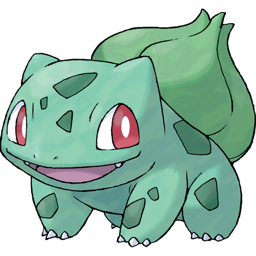

a drawing of a green pokemon with red eyes


In [ ]:

ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
sample = ds[0]
display(sample["image"].resize((256, 256)))
print(sample["text"])

In [ ]:
captions = []
# images = []

for i in range(len(cdf)):
    row = cdf.iloc[i]
    img_path = preprocessed_dir / row.handlabeled_rel_path
    print(img_path)

    raw_image = Image.open(img_path).convert('RGB')

    inputs = processor(raw_image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)

    captions.append(caption)
    # images.append(raw_image)

blip_df['caption'] = captions

/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb77p043.jpg


/Users/al/miniconda3_m1/envs/py310/lib/python3.10/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb67p021.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb25p227.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb48p057.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb77p044.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb11p024.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb67p006--kitchen-nap.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb68p093.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb45p121.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb69p013.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb48p068.jpg
/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings/sb55p055.jpg
/Users/al/singleline_data/rast

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
blip_df['caption'] = ''

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
blip_df.reindex()

,indiv_fname,visual_rel_path,visual_abs_path,handlabeled_rel_path,handlabeled_metacluster_name,handlabeled_metacluster_id,handlabeled_metacluster_was_correct,preprocessed_abs_path,handlabeled_abs_path,emb_csv_cropped,drawings_cluster_id,drawings_cluster_dist,caption
idx,,,,,,,,,,,,,
0,sb77p043.jpg,1_watercolors/sb77p043.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/1_watercolors/sb77p043.jpg,0_drawings/sb77p043.jpg,0_drawings,0,False,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb77p043.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb77p043.jpg,"-0.6198182,-0.5714155,0.2937309,0.2691822,-0.6254566,-0.46855158,-0.7267234,-0.4896673,-0.7537334,-0.42715576,2.241211,-0.013144195,-0.30681813,-0.6266761,0.43516117,-0.57515705,-0.5467274,-0.5245168,1.3334948,2.1400952,-0.64108604,-0.55193967,-0.5446661,-0.6779002,-0.57759243,-0.6690378,0.38178188,-0.5982413,-0.50063276,-0.21540937,0.4948988,-0.67007643,-0.52171326,-0.4592305,1.8570362,-0.6186755,0.94023055,-0.57338566,0.5270257,-0.6179389,2.302543,1.1004333,0.15528035,-0.6682474,1.890626,-0.59257406,1.331521,-0.6001429,1.5220151,0.93749076,-0.59497476,-0.66552746,-0.6482407,-0.4732165,0....",3,217.249590,
1,sb67p021.jpg,0_drawings/sb67p021.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb67p021.jpg,0_drawings/sb67p021.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb67p021.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb67p021.jpg,"-0.20756221,-0.24843562,0.29454154,-0.6553513,-0.6254566,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.9697293,-0.72562873,-0.662768,-0.6266761,-0.23836556,0.4814458,-0.5467274,-0.6520286,0.838902,-0.6497359,-0.57338166,-0.55193967,-0.5446661,-0.28419846,1.6012006,-0.6690378,-0.4518578,-0.0104218125,-0.73986673,-0.3002332,-0.68509877,-0.67007643,-0.36297536,-0.4592305,-0.600525,-0.6186755,-0.73933,-0.57338566,-0.65925777,1.6904012,-0.61049384,-0.58021957,0.508085,0.14767355,0.8082305,-0.59257406,-0.6157326,-0.6001429,-0.651804,-0.30467254,0.17396247,-0.66552746,-0.6482407,-0.0...",2,169.947700,
2,sb25p227.jpg,0_drawings/sb25p227.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb25p227.jpg,0_drawings/sb25p227.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb25p227.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb25p227.jpg,"-0.6198182,-0.428226,-0.73929733,-0.6553513,-0.49369657,-0.65341413,-0.7267234,-0.4896673,-0.7537334,-0.28293163,-0.62038505,-0.32824886,2.5504894,-0.6266761,0.8397537,0.85716057,-0.5467274,-0.058725297,0.64954805,-0.6497359,-0.64108604,-0.36876833,-0.5446661,-0.29563427,0.08626467,-0.6690378,-0.4518578,0.64337015,-0.73986673,0.018805295,-0.68509877,-0.67007643,1.5876667,-0.4592305,-0.600525,-0.6186755,0.28688914,-0.57338566,-0.65925777,1.6810645,-0.61049384,1.8564332,-0.6189488,-0.6682474,-0.75794554,-0.59257406,-0.6157326,-0.6001429,-0.63579994,-0.45296612,-0.29925343,-0.0263654,-0.64824...",3,162.882430,
3,sb48p057.jpg,0_drawings/sb48p057.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/02_VISUAL_CATEGORIES/0_drawings/sb48p057.jpg,0_drawings/sb48p057.jpg,0_drawings,0,True,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/10_SIMPLE_CROP/0_drawings/sb48p057.jpg,/Users/al/Dropbox/2-Areas/2-Sketchbooks/datasets/full-v2/03_VISUAL_HAND_LABELED/0_drawings/sb48p057.jpg,"-0.34353483,-0.5714155,2.2665114,-0.6553513,-0.42076486,-0.6254998,-0.7267234,-0.4896673,-0.7537334,-0.42715576,0.6137707,-0.72562873,0.2611376,1.0485492,0.91806084,-0.452704,-0.5467274,-0.6520286,0.621349,-0.6497359,-0.64108604,-0.55193967,-0.5446661,-0.6779002,0.7967064,0.011958599,-0.4518578,-0.25104153,-0.6493137,-0.452119

In [ ]:
cdf['caption'] = captions

In [ ]:
for i, c in enumerate(captions):
    if '"' in c:
        print(f"{i} - [{c}]")
    # if "'" in c:
    #     print(f"{i} - [{c}]")
    if "/" in c:
        print(f"{i} - [{c}]")
    if "?" in c:
        print(f"{i} - [{c}]")
    if ":" in c:
        print(f"{i} - [{c}]")
    if '\\' in c:
        print(f"{i} - [{c}]")

In [ ]:
captions[:20]

['drawing of two women with long hair and a hat',
 'a drawing of two people in suits and ties one is wearing a hat',
 'sketches of a man and a woman in a suit and tie',
 'a drawing of a man with a hat on his head',
 'drawing of a man with a hat and glasses on his head',
 'drawing of a woman with a hat and a scarf on',
 'sketches of a person laying on a ground with a pair of skis',
 'a drawing of a woman with a hand in her right hand',
 'a drawing of a man with a hat and a tie',
 'a drawing of a woman with a tennis racket in her hand',
 'a drawing of a woman with glasses and a bow tie',
 'a drawing of a woman in a dress is standing with her legs crossed',
 'drawing of a man with a knife and a woman with a hat',
 'sketches of a man with a knife and a knife in his hand',
 'a drawing of two people with different expressions on their faces',
 'sketches of a man with a hat and a suit on',
 'sketches of a woman sitting on a chair with a laptop',
 'a drawing of a drawing of a man and a woman',

In [ ]:
cdf['file_name'] = cdf['indiv_fname']
cdf['text'] = cdf['caption']

metadata_df = cdf[['file_name', 'text']]
metadata_df.head()

,file_name,text
idx,,
0,sb77p043.jpg,drawing of two women with long hair and a hat
1,sb67p021.jpg,a drawing of two people in suits and ties one is wearing a hat
2,sb25p227.jpg,sketches of a man and a woman in a suit and tie
3,sb48p057.jpg,a drawing of a man with a hat on his head
4,sb77p044.jpg,drawing of a man with a hat and glasses on his head


In [ ]:
csv_fname = preprocessed_dir / '0_drawings/metadata.csv'

metadata_df.to_csv(csv_fname, index=False)

!head {csv_fname}

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
file_name,text
sb77p043.jpg,drawing of two women with long hair and a hat
sb67p021.jpg,a drawing of two people in suits and ties one is wearing a hat
sb25p227.jpg,sketches of a man and a woman in a suit and tie
sb48p057.jpg,a drawing of a man with a hat on his head
sb77p044.jpg,drawing of a man with a hat and glasses on his head
sb11p024.jpg,drawing of a woman with a hat and a scarf on
sb67p006--kitchen-nap.jpg,sketches of a person laying on a ground with a pair of skis
sb68p093.jpg,a drawing of a woman with a hand in her right hand
sb45p121.jpg,a drawing of a man with a hat and a tie


In [ ]:
dataset = load_dataset("imagefolder", str(preprocessed_dir / '0_drawings'))

InvalidConfigName: Bad characters from black list '<>:/\|?*' found in '/Users/al/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings'. They could create issues when creating a directory for this config on Windows filesystem.

In [ ]:
%cd {preprocessed_dir}

/Users/al/Library/CloudStorage/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP


In [ ]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/al/Library/CloudStorage/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP


In [ ]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/al/Library/CloudStorage/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP


In [ ]:
dataset = load_dataset("imagefolder", '0_drawings')

Resolving data files:   0%|          | 0/2928 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/5 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [ ]:
%cd 0_drawings

/Users/al/Library/CloudStorage/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings


In [ ]:
!pwd

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/al/Library/CloudStorage/Dropbox/2-Areas/2-Sketchbooks/singleline_data/raster/epoch-20231214/10_SIMPLE_CROP/0_drawings


In [ ]:
dataset = load_dataset("imagefolder", '.')

Resolving data files:   0%|          | 0/1924 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /Users/al/.cache/huggingface/datasets/imagefolder/.-7a63305572a30d5c/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 1923
    })
})

In [ ]:
HF_DATASET = "singlelinexyz/singlelines_raster"

In [ ]:
dataset.push_to_hub(HF_DATASET)

Pushing split train to the Hub.


Map:   0%|          | 0/1923 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()